# MCQ Underperformance Debug Playbook (Human-in-the-Loop)

This notebook is the **single entrypoint** for diagnosing why MCQ models underperform.

## What this notebook does
- Builds a unified debug bundle from the latest runs in `results/mcq-order`.
- Produces visual diagnostics (accuracy, parse failures, option-count difficulty, prediction bias, audio-vs-no-audio deltas).
- Creates a **human review queue** with high-priority examples for manual inspection.
- Provides a reproducible, explicit workflow for root-cause analysis.


## Debug Plan (End-to-End)

1. **Sanity and data integrity checks**
   - Validate run registry and artifact consistency.
   - Confirm parse-invalid/missing rates are not silently dominating.
2. **Model-level performance diagnostics**
   - Compare latest accuracy per model.
   - Compare entropy and label-bias signatures.
3. **Audio contribution diagnostics**
   - Pair audio vs no-audio runs by model.
   - Quantify agreement, both-correct, audio-only-correct, no-audio-only-correct.
4. **Difficulty-shape diagnostics**
   - Visualize accuracy by `n_options` per model.
5. **Human review loop**
   - Inspect high-priority disagreement cases from `human_review_queue_topk.csv`.
   - Review question/options/predictions/raw outputs + local audio path.
6. **Actionable hypothesis loop**
   - Capture concrete hypotheses and next experiments from evidence.


In [1]:
from pathlib import Path
import json
import sys

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Image, Audio

# Make src importable from notebooks/
REPO_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
SRC_ROOT = REPO_ROOT / 'src'
if str(SRC_ROOT) not in sys.path:
    sys.path.insert(0, str(SRC_ROOT))

from utils.debug_mcq_underperformance import build_debug_bundle


In [2]:
# === Config ===
RESULTS_ROOT = REPO_ROOT / 'results' / 'mcq-order'
DATASET_PATH = REPO_ROOT / 'data' / 'mcq_event_timeline_strong.jsonl'
DEBUG_OUT_DIR = RESULTS_ROOT / 'debug_bundle'
TOP_K_REVIEW = 200

print('REPO_ROOT   =', REPO_ROOT)
print('RESULTS_ROOT=', RESULTS_ROOT)
print('DATASET_PATH=', DATASET_PATH)
print('DEBUG_OUT   =', DEBUG_OUT_DIR)


REPO_ROOT   = /Users/younisskandah/Documents/GitHub/TACoBeLAL
RESULTS_ROOT= /Users/younisskandah/Documents/GitHub/TACoBeLAL/results/mcq-order
DATASET_PATH= /Users/younisskandah/Documents/GitHub/TACoBeLAL/data/mcq_event_timeline_strong.jsonl
DEBUG_OUT   = /Users/younisskandah/Documents/GitHub/TACoBeLAL/results/mcq-order/debug_bundle


In [3]:
summary = build_debug_bundle(
    results_root=RESULTS_ROOT,
    dataset_path=DATASET_PATH,
    output_dir=DEBUG_OUT_DIR,
    top_k_review=TOP_K_REVIEW,
)
summary


FileNotFoundError: [Errno 2] No such file or directory: 'results/mcq-order/audio-flamingo-3/20260217_140006/decisions.jsonl'

In [ ]:
latest_runs = pd.read_csv(DEBUG_OUT_DIR / 'latest_runs.csv')
run_registry = pd.read_csv(DEBUG_OUT_DIR / 'run_registry_enriched.csv')

display(Markdown('### Latest Run Selection'))
display(latest_runs.sort_values(['model_name']))

display(Markdown('### Latest Runs (compact)'))
display(latest_runs[[
    'model_name','run_id','examples','accuracy','parse_invalid','missing_predictions',
    'prediction_entropy','answer_entropy','use_audio'
]].sort_values('accuracy', ascending=False))


### Latest Run Selection

,run_id,task_id,model_name,examples,correct,accuracy,elapsed_seconds,average_latency_ms,started_at_utc,finished_at_utc,...,decisions_path,run_dir,metrics_path,run_config_path,analysis_path,parse_invalid,missing_predictions,prediction_entropy,answer_entropy,use_audio
0,20260217_130051,MCQ-ORDER,audio-flamingo-3-no-audio,1000,272,0.272,346.676806,346.676806,2026-02-17 13:00:51.704954+00:00,2026-02-17 13:06:38.695388+00:00,...,results/mcq-order/audio-flamingo-3-no-audio/20...,results/mcq-order/audio-flamingo-3-no-audio/20...,results/mcq-order/audio-flamingo-3-no-audio/20...,results/mcq-order/audio-flamingo-3-no-audio/20...,results/mcq-order/audio-flamingo-3-no-audio/20...,0,0,2.194568,2.603295,False
1,20260217_122811,MCQ-ORDER,qwen2-audio-7b-instruct,1000,177,0.177,220.770390,220.770390,2026-02-17 12:28:11.658204+00:00,2026-02-17 12:32:14.037233+00:00,...,results/mcq-order/qwen2-audio-7b-instruct/2026...,results/mcq-order/qwen2-audio-7b-instruct/2026...,results/mcq-order/qwen2-audio-7b-instruct/2026...,results/mcq-order/qwen2-audio-7b-instruct/2026...,results/mcq-order/qwen2-audio-7b-instruct/2026...,0,0,2.136248,2.603295,True
2,20260217_120455,MCQ-ORDER,qwen2-audio-7b-instruct-no-audio,1000,239,0.239,223.457149,223.457149,2026-02-17 12:04:55.937109+00:00,2026-02-17 12:08:59.615249+00:00,...,results/mcq-order/qwen2-audio-7b-instruct-no-a...,results/mcq-order/qwen2-audio-7b-instruct-no-a...,results/mcq-order/qwen2-audio-7b-instruct-no-a...,results/mcq-order/qwen2-audio-7b-instruct-no-a...,results/mcq-order/qwen2-audio-7b-instruct-no-a...,43,0,2.279277,2.603295,False
3,20260217_124103,MCQ-ORDER,random,1000,299,0.299,0.013642,0.000784,2026-02-17 12:41:03.174172+00:00,2026-02-17 12:41:03.187822+00:00,...,results/mcq-order/random/20260217_124103/decis...,results/mcq-order/random/20260217_124103,results/mcq-order/random/20260217_124103/metri...,results/mcq-order/random/20260217_124103/run_c...,results/mcq-order/random/20260217_124103/analy...,0,0,2.554288,2.603295,True


### Latest Runs (compact)

,model_name,run_id,examples,accuracy,parse_invalid,missing_predictions,prediction_entropy,answer_entropy,use_audio
3,random,20260217_124103,1000,0.299,0,0,2.554288,2.603295,True
0,audio-flamingo-3-no-audio,20260217_130051,1000,0.272,0,0,2.194568,2.603295,False
2,qwen2-audio-7b-instruct-no-audio,20260217_120455,1000,0.239,43,0,2.279277,2.603295,False
1,qwen2-audio-7b-instruct,20260217_122811,1000,0.177,0,0,2.136248,2.603295,True


### Plot: Accuracy by model

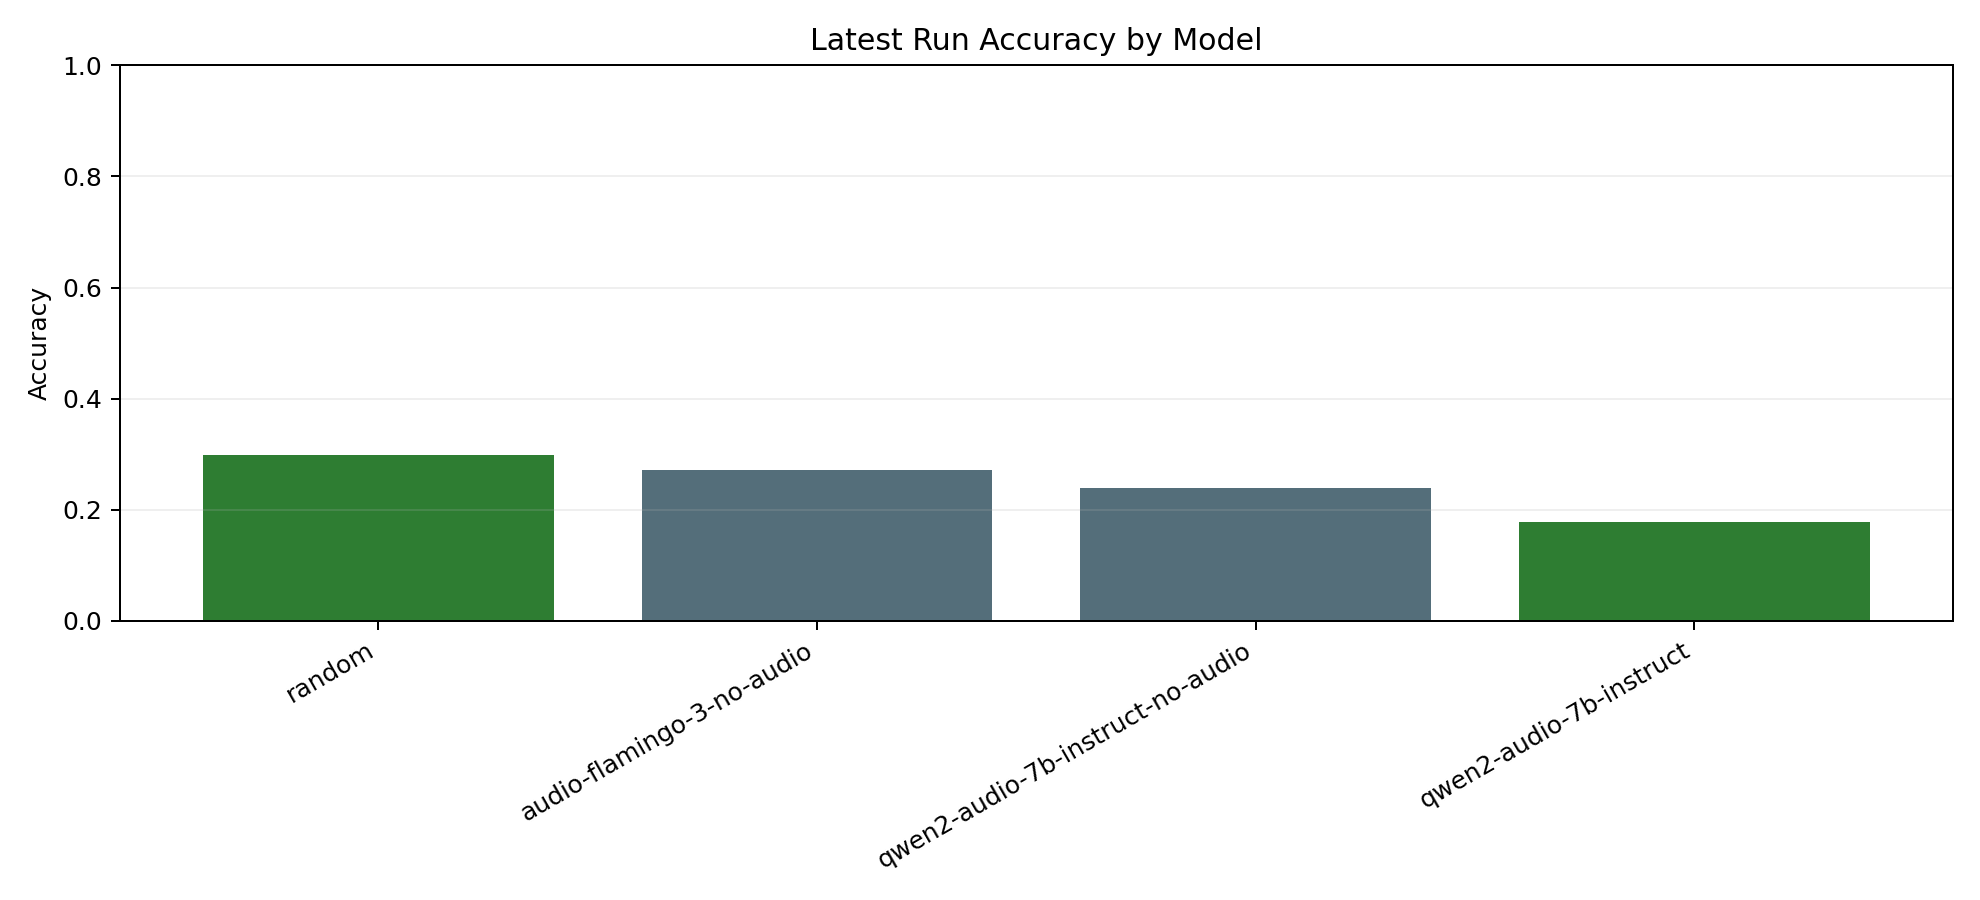

### Plot: Invalid/missing rates

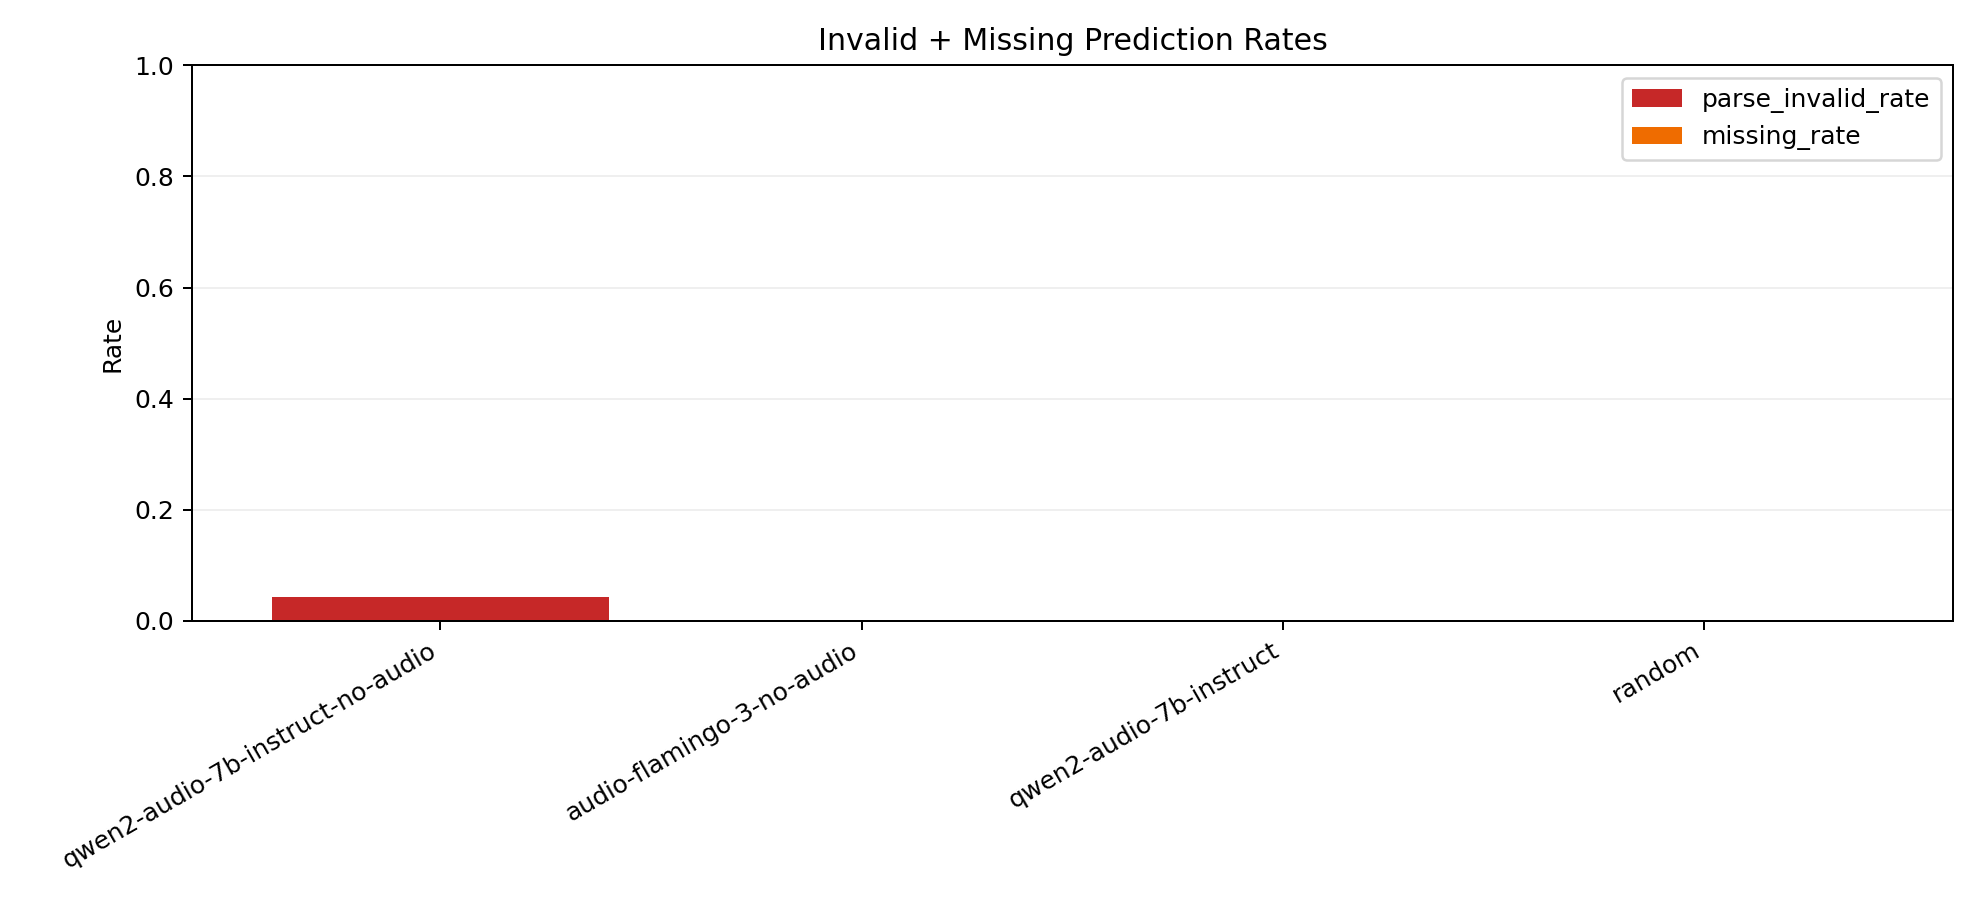

### Plot: Accuracy by option count

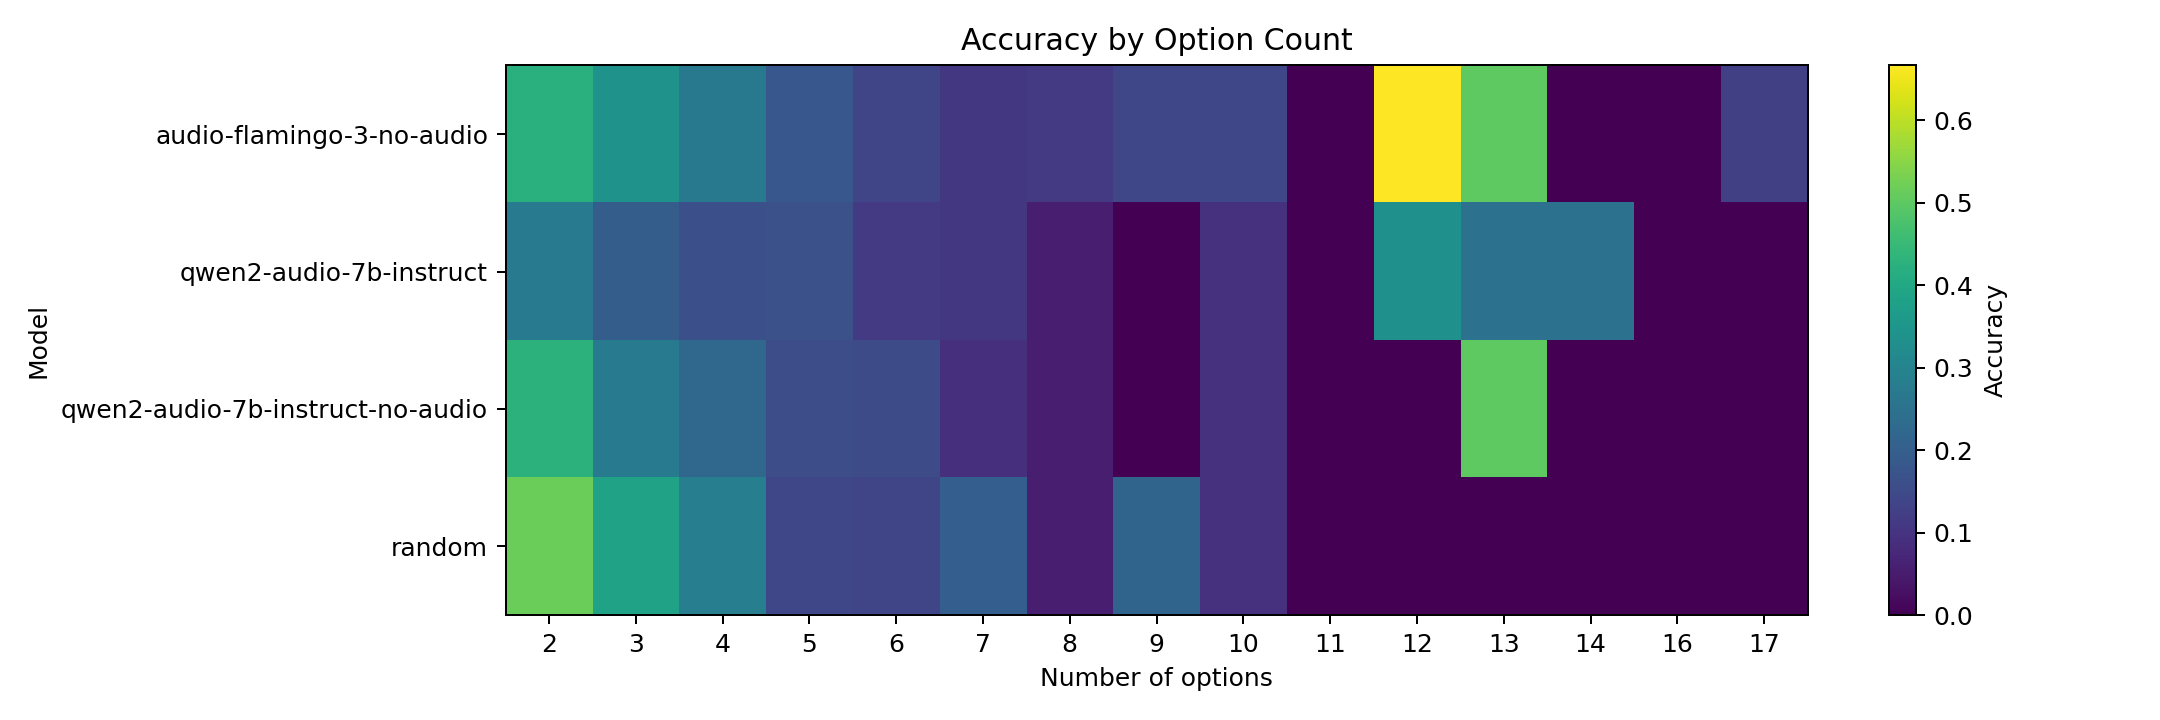

### Plot: Prediction bias heatmap

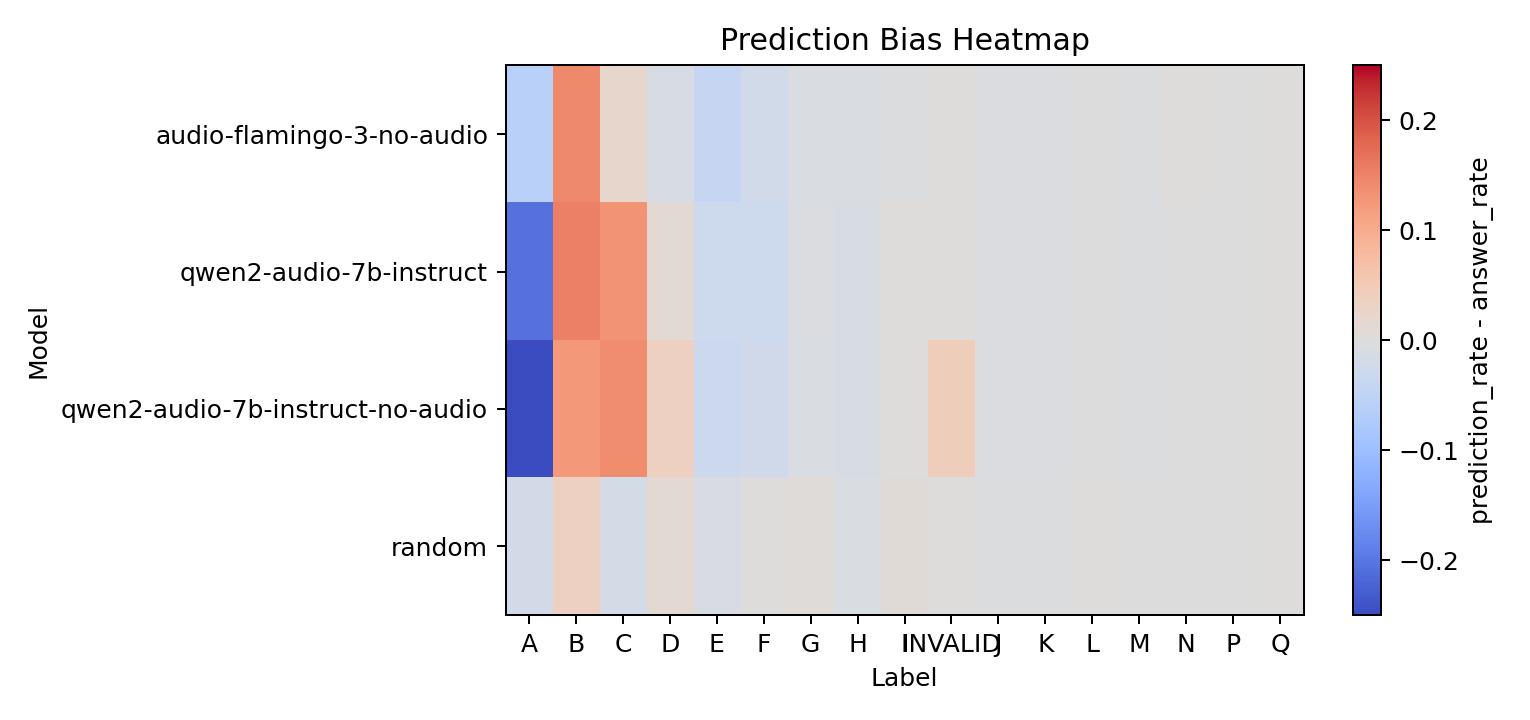

In [ ]:
display(Markdown('### Plot: Accuracy by model'))
display(Image(filename=str(DEBUG_OUT_DIR / 'plot_accuracy_by_model.png')))

display(Markdown('### Plot: Invalid/missing rates'))
display(Image(filename=str(DEBUG_OUT_DIR / 'plot_invalid_missing_rates.png')))

display(Markdown('### Plot: Accuracy by option count'))
display(Image(filename=str(DEBUG_OUT_DIR / 'plot_accuracy_by_option_count.png')))

display(Markdown('### Plot: Prediction bias heatmap'))
display(Image(filename=str(DEBUG_OUT_DIR / 'plot_prediction_bias.png')))


In [ ]:
pairs_path = DEBUG_OUT_DIR / 'audio_ablation_pairs.csv'
if pairs_path.exists():
    pair_df = pd.read_csv(pairs_path)
    display(Markdown('### Audio vs No-Audio Pair Summary'))
    display(pair_df)
    display(Markdown('### Plot: Audio vs No-Audio Accuracy'))
    display(Image(filename=str(DEBUG_OUT_DIR / 'plot_audio_ablation_accuracy.png')))
else:
    display(Markdown('### Audio vs No-Audio Pair Summary'))
    display(Markdown('_No matched audio/no-audio model pairs found in latest runs._'))


In [ ]:
queue_path = DEBUG_OUT_DIR / 'human_review_queue_topk.csv'
if queue_path.exists():
    review_queue = pd.read_csv(queue_path)
    display(Markdown(f'### Human Review Queue (Top {len(review_queue)} rows)'))
    display(review_queue.head(30))
else:
    review_queue = pd.DataFrame()
    display(Markdown('### Human Review Queue'))
    display(Markdown('_No review queue generated._'))


In [ ]:
# Load dataset index for option text lookup
example_index = {}
with open(DATASET_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        if line.strip():
            row = json.loads(line)
            example_index[row['id']] = row


def show_review_case(example_id: str):
    if review_queue.empty:
        print('Review queue is empty.')
        return

    row = review_queue[review_queue['example_id'] == example_id]
    if row.empty:
        print(f'No row found for example_id={example_id}')
        return
    rec = row.iloc[0].to_dict()

    display(Markdown(f"## Example: `{example_id}`"))
    display(Markdown(f"**Pair:** {rec.get('pair_name','')}  "))
    display(Markdown(f"**Category:** {rec.get('category','')} (priority={rec.get('priority','')})  "))
    display(Markdown(f"**Question:** {rec.get('question','')}"))
    display(Markdown(f"**Answer label:** {rec.get('answer_label','')}  "))
    display(Markdown(f"**Audio model prediction:** {rec.get('audio_prediction','')}  "))
    display(Markdown(f"**No-audio model prediction:** {rec.get('noaudio_prediction','')}  "))

    ex = example_index.get(example_id, {})
    options = ex.get('options', [])
    if options:
        text = '
'.join([f"- {opt.get('label','')}. {opt.get('text','')}" for opt in options])
        display(Markdown('**Options**
' + text))

    audio_file = rec.get('audio_filename', '')
    if isinstance(audio_file, str) and audio_file:
        local_audio = REPO_ROOT / 'data' / 'audio' / audio_file
        display(Markdown(f"**Local audio path:** `{local_audio}`"))
        if local_audio.exists():
            display(Audio(filename=str(local_audio)))
        else:
            display(Markdown('_Audio file not found locally._'))


# Example usage:
# show_review_case('100476.mp3__0')


## Human Workflow Checklist

Use this checklist during triage sessions:

- Confirm whether failures cluster by `n_options` rather than by audio usage.
- For `audio_only_correct` and `noaudio_only_correct` rows, inspect if cues are textual shortcuts.
- For `both_wrong_diff_pred` rows, inspect if option semantics are near-duplicate or ambiguous.
- Track hypotheses in a separate table with columns:
  - hypothesis
  - supporting examples
  - confidence
  - proposed experiment
  - expected outcome


## Baseline Diagnostics

These slices show whether model performance is above trivial priors (random, majority-label, always-none) and where calibration is failing.


In [ ]:
model_baselines = pd.read_csv(DEBUG_OUT_DIR / 'model_baselines.csv')
display(Markdown('### Model vs Baselines'))
display(model_baselines.sort_values('accuracy', ascending=False))

answer_type_diag = pd.read_csv(DEBUG_OUT_DIR / 'answer_type_diagnostics.csv')
display(Markdown('### Answer Type Diagnostics'))
display(answer_type_diag)

for plot_name in [
    'plot_accuracy_by_answer_type.png',
    'plot_model_vs_baselines.png',
    'plot_none_calibration.png',
]:
    p = DEBUG_OUT_DIR / plot_name
    if p.exists():
        display(Markdown(f'### {plot_name}'))
        display(Image(filename=str(p)))


## AudioFlamingo ID Integrity

Checks whether output IDs can be joined to mapping keys directly or only via basename fallback (important for cross-host path differences).


In [ ]:
integrity_path = DEBUG_OUT_DIR / 'audioflamingo_id_integrity.csv'
if integrity_path.exists():
    integrity = pd.read_csv(integrity_path)
    display(integrity)
else:
    display(Markdown('_No latest AudioFlamingo run found in this debug bundle._'))
